In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random

In [2]:
class EnergyEnv(gym.Env):
    def __init__(self):
        super(EnergyEnv, self).__init__()

        # Action space: 0 - Use solar, 1 - Store in battery, 2 - Draw from battery, 3 - Draw from grid
        self.action_space = spaces.Discrete(4)

        # Observation space: [battery_level, solar_energy, load, forecast_probability]
        self.observation_space = spaces.Box(low=np.array([1000, 0, 0, 0]),
                                            high=np.array([10000, 3000, 1000, 1]),
                                            dtype=np.float32)

        # Variables for monthly simulation with forecast probability
        self.forecast_probability = 0.23  # 23% chance of an overcast day
        self.potential_number_of_days_without_solar = 2

        # Set up 24-hour cycle of solar energy and demand
        self.solar_energy = {
            f'hour{hour}': value * 1000 * self.potential_number_of_days_without_solar
            for hour, value in enumerate([0, 0, 0, 0, 0, 0, 0.15, 0.4, 0.6, 0.8, 0.9, 0.96,
                                          0.98, 0.9, 0.75, 0.58, 0.37, 0.14, 0, 0, 0, 0, 0, 0])
        }
        self.load = {
            f'hour{hour}': value * 1000
            for hour, value in enumerate([0.08, 0.07, 0.07, 0.07, 0.25, 0.37, 0.41, 0.37,
                                          0.3, 0.31, 0.37, 0.41, 0.53, 0.4, 0.34, 0.33, 0.34,
                                          0.5, 0.9, 0.75, 0.53, 0.37, 0.17, 0.12])
        }

        # Battery properties
        self.battery_capacity = 10 * self.potential_number_of_days_without_solar* 1000  # Wh
        self.min_battery = 1 * 1000  # Minimum charge 10%
        self.max_battery = 10 * self.potential_number_of_days_without_solar* 1000  # Full charge

        # Initialize the state of the environment
        self.current_hour = 0
        self.battery_level = 2.35 * 1000  # Starting battery level in Wh
        self.grid_usage = 0  # Tracking grid energy usage over the month
        self.battery_charge_and_discharge_rate = 5 * 1000  # Wh

    def reset(self):
        """Resets the environment to the initial state for a new episode."""
        self.current_hour = 0
        self.grid_usage = 0
        self.battery_level = 2.35 * 1000
        return np.array([self.battery_level, self.solar_energy['hour0'], self.load['hour0'], self.forecast_probability], dtype=np.float32)

    def step(self, action):
        """Take an action and return the new state, reward, and done signal."""
        # Determine if the day is overcast
        day_index = self.current_hour // 24
        is_overcast = np.random.rand() < self.forecast_probability

        # Get solar energy and load for the current hour, accounting for overcast
        hour_in_day = self.current_hour % 24
        solar_energy = 0 if is_overcast else self.solar_energy[f'hour{hour_in_day}']
        load = self.load[f'hour{hour_in_day}']
        reward = 0

        # Process the selected action
        if action == 0:  # Use solar energy to meet load
            if solar_energy >= load:
                wastage = solar_energy - load
                reward = load - wastage
            else:
                load_deficit = load - solar_energy
                self.grid_usage += load_deficit
                reward = -load_deficit
        elif action == 1:  # Store solar energy in battery
            if (self.battery_level + solar_energy) >= self.max_battery:
                wastage = (self.battery_level + solar_energy) - self.max_battery
                stored_energy = self.max_battery - self.battery_level
                self.battery_level = self.max_battery
                self.grid_usage += load
                reward = -load - wastage + stored_energy
            else:
                self.battery_level += solar_energy
                self.grid_usage += load
                reward = -load + solar_energy
        elif action == 2:  # Draw from battery
            if (self.battery_level - load) < self.min_battery:
                if self.battery_level > self.min_battery:
                    available_battery_energy = self.battery_level - self.min_battery
                    self.battery_level = self.min_battery
                    self.grid_usage += load - available_battery_energy
                    reward = -(load - available_battery_energy)
                else:
                    self.battery_level = self.min_battery
                    self.grid_usage += load
                    reward = -load
            else:
                self.battery_level -= load
                reward = load
        elif action == 3:  # Draw from grid
            self.grid_usage += load
            reward = -load

        # Advance the hour
        self.current_hour += 1
        done = self.current_hour == 24 * 30  # End after 30 days

        # Get the next state
        next_solar_energy = 0 if is_overcast else self.solar_energy[f'hour{self.current_hour % 24}']
        next_load = self.load[f'hour{self.current_hour % 24}']
        next_state = np.array([self.battery_level, next_solar_energy, next_load, self.forecast_probability], dtype=np.float32)

        return next_state, reward, done, {}

    def render(self, mode='human'):
        """Display the environment state."""
        print(f'Hour: {self.current_hour}, Battery Level: {self.battery_level}, Grid Usage: {self.grid_usage}')

In [3]:

class QLearningAgent:

    def __init__(self, env, learning_rate=0.1, discount_factor=0.999, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((100, 100, 100, env.action_space.n))  # Initialize Q-table with 4 dimensions

        # Initialize the record for actions taken in each episode
        self.actions_record = []

    def discretize(self, state):
        """Discretize the continuous state space into manageable buckets."""
        battery, solar, load, _ = state  # Remove the forecast component if not needed
        battery_idx = min(int((battery / self.env.battery_capacity) * 100), 99)
        solar_idx = min(int((solar / 3000) * 100), 99)
        load_idx = min(int((load / 1000) * 100), 99)
        
        return battery_idx, solar_idx, load_idx

   
    def choose_action(self, state):
        """Choose the next action prioritizing the highest Q-value action."""
        battery_idx, solar_idx, load_idx = self.discretize(state)
        
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  # Explore: Random action
        else:
            # Exploit: Choose the action with the highest Q-value
            q_values = self.q_table[battery_idx, solar_idx, load_idx]
            max_reward_actions = np.where(q_values == q_values.max())[0]  # Select actions with max Q-value
            return np.random.choice(max_reward_actions)  # Randomly select among best actions if multiple
    

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-table using the Q-learning formula."""
        battery_idx, solar_idx, load_idx = self.discretize(state)
        next_battery_idx, next_solar_idx, next_load_idx = self.discretize(next_state)
        
        best_next_action = np.argmax(self.q_table[next_battery_idx, next_solar_idx, next_load_idx])
        td_target = reward + self.discount_factor * self.q_table[next_battery_idx, next_solar_idx, next_load_idx, best_next_action]
        td_error = td_target - self.q_table[battery_idx, solar_idx, load_idx, action]
        
        self.q_table[battery_idx, solar_idx, load_idx, action] += self.learning_rate * td_error


    

    def train(self, episodes=1000, max_steps=720):
        rewards = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            episode_actions = []

            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)

                state = next_state
                total_reward += reward
                episode_actions.append(action)

                if done:
                    break

            rewards.append(total_reward)
            self.actions_record.append(episode_actions)  # Store actions for this episode
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon}")

        # Plot rewards and calculate moving average
        self.plot_rewards(rewards)
        self.plot_moving_average(rewards)

        # Get and plot the most frequent high-reward action pattern
        best_action_sequence = self.extract_optimal_actions(rewards, self.actions_record)
        self.plot_action_sequence(best_action_sequence)
        
        # Separate plots for battery level and grid usage for optimal actions
        self.plot_battery_levels(best_action_sequence)
        self.plot_grid_usage(best_action_sequence)

        return rewards



    

    def plot_rewards(self, rewards):
        """Plot the rewards over episodes."""
        plt.figure(figsize=(12, 5))
        plt.plot(rewards, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Rewards Over Time")
        plt.legend()
        plt.show()

    def plot_moving_average(self, rewards, window=50):
        """Plot a moving average of rewards."""
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.figure(figsize=(12, 5))
        plt.plot(moving_avg, label=f"{window}-Episode Moving Average")
        plt.xlabel("Episodes")
        plt.ylabel("Average Reward")
        plt.title("Moving Average of Rewards")
        plt.legend()
        plt.show()

    def extract_optimal_actions(self, rewards, actions_record):
        """Extract the action sequence with the highest rewards that repeats the most."""
        top_reward_index = np.argmax(rewards)
        best_action_sequence = actions_record[top_reward_index]
        
        # Convert actions to descriptive text
        action_descriptions = [self.describe_action(action, i) for i, action in enumerate(best_action_sequence)]
        
        print("Optimal Action Sequence:")
        for action_desc in action_descriptions:
            print(action_desc)
        
        return best_action_sequence

    def describe_action(self, action, hour):
        """Return a description of the action at a specific hour."""
        actions = ["Use solar energy", "Store in battery", "Draw from battery", "Draw from grid"]
        return f"hour{hour}: {actions[action]}"

    def plot_action_sequence(self, best_action_sequence):
        """Plot the optimal action sequence over a day or month."""
        plt.figure(figsize=(12, 5))
        plt.plot(best_action_sequence, label="Optimal Actions")
        plt.xlabel("Hour")
        plt.ylabel("Action Taken")
        plt.title("Optimal Action Sequence Over Time")
        plt.legend()
        plt.show()

    def plot_battery_levels(self, best_action_sequence):
        """Simulate and plot battery levels when the optimal actions are taken."""
        self.env.reset()
        battery_levels = []

        for action in best_action_sequence:
            _, _, _, info = self.env.step(action)
            battery_levels.append(self.env.battery_level)

        plt.figure(figsize=(12, 5))
        plt.plot(battery_levels, label="Battery Level")
        plt.xlabel("Hour")
        plt.ylabel("Battery Level (Wh)")
        plt.title("Battery Levels for Optimal Actions")
        plt.legend()
        plt.show()

    def plot_grid_usage(self, best_action_sequence):
        """Simulate and plot grid usage when the optimal actions are taken."""
        self.env.reset()
        grid_usages = []

        for action in best_action_sequence:
            _, _, _, info = self.env.step(action)
            grid_usages.append(self.env.grid_usage)

        plt.figure(figsize=(12, 5))
        plt.plot(grid_usages, label="Grid Usage")
        plt.xlabel("Hour")
        plt.ylabel("Grid Usage (Wh)")
        plt.title("Grid Usage for Optimal Actions")
        plt.legend()
        plt.show()
        
    def calculate_total_grid_usage(self, best_action_sequence):
        """Calculate the total grid usage when the optimal actions are taken."""
        self.env.reset()
        total_grid_usage = 0

        for action in best_action_sequence:
            _, _, _, info = self.env.step(action)
            total_grid_usage += self.env.grid_usage - total_grid_usage # Sum grid usage after each action

        return total_grid_usage
    def compare_grid_usage(self, best_action_sequence1, best_action_sequence2, best_action_sequence3):
        """Simulate and plot grid usage for three different action sequences."""
        # Reset environment and initialize grid usage lists
        self.env.reset()
        grid_usages1 = []
        grid_usages2 = []
        grid_usages3 = []
        
        # Collect grid usage for best_action_sequence1
        for action in best_action_sequence1:
            _, _, _, info = self.env.step(action)
            grid_usages1.append(self.env.grid_usage)
        
        # Reset environment for second sequence
        self.env.reset()
        for action in best_action_sequence2:
            _, _, _, info = self.env.step(action)
            grid_usages2.append(self.env.grid_usage)
            
        # Reset environment for third sequence
        self.env.reset()
        for action in best_action_sequence3:
            _, _, _, info = self.env.step(action)
            grid_usages3.append(self.env.grid_usage)
    
        # Plot settings
        plt.figure(figsize=(12, 6))
        
        # Plot the three grid usages with different colors
        colors = ['blue', 'green', 'purple']
        grid_usages = [grid_usages1, grid_usages2, grid_usages3]
        labels = ["Grid Usage for Brute Force Actions", "Grid Usage for MPC Actions", "Grid Usage for Q-Learning"]
        
        for i, usage in enumerate(grid_usages):
            plt.plot(usage, color=colors[i], label=labels[i])
            # Mark final data point in red and project horizontal line
            plt.plot(len(usage) - 1, usage[-1], 'ro')
            plt.axhline(y=usage[-1], color=colors[i], linestyle='--')
    
        # Plot enhancements
        plt.xlabel("Hour")
        plt.ylabel("Grid Usage (Wh)")
        plt.title("Grid Usage for Three Optimal Action Sequences")
        plt.legend()
        plt.grid(True)
        plt.show()

    def ultra_grid_usage(self, total_grid_usage_actions, standard_usage_actions, brute_force_actions, MPC_actions, optimal_actions):
        """Simulate and plot grid usage for five different action sequences."""
        # Reset environment and initialize grid usage lists
        self.env.reset()
        grid_usages = []
    
        # List of action sequences
        action_sequences = [
            total_grid_usage_actions,
            standard_usage_actions,
            brute_force_actions,
            MPC_actions,
            optimal_actions
        ]
        
        # Collect grid usage for each action sequence
        for actions in action_sequences:
            self.env.reset()  # Reset environment for each sequence
            grid_usage = []
            for action in actions:
                _, _, _, info = self.env.step(action)
                grid_usage.append(self.env.grid_usage)
            grid_usages.append(grid_usage)
    
        # Plot settings
        plt.figure(figsize=(12, 6))
        
        # Define colors for each action sequence
        colors = ['blue', 'green', 'purple', 'orange', 'teal']
        labels = [
            "Total Grid Usage Actions",
            "Standard Usage Actions",
            "Brute Force Actions",
            "MPC Actions",
            "Q-Learning Actions"
        ]
        
        # Plot each grid usage
        for i, usage in enumerate(grid_usages):
            plt.plot(usage, color=colors[i], label=labels[i])
            # Mark final data point in red and project horizontal line
            plt.plot(len(usage) - 1, usage[-1], 'ro')  # Red dot for final data point
            plt.axhline(y=usage[-1], color=colors[i], linestyle='--')  # Dotted line for final value
    
        # Plot enhancements
        plt.xlabel("Hour")
        plt.ylabel("Grid Usage (Wh)")
        plt.title("Grid Usage for Five Action Sequences")
        plt.legend()
        plt.grid(True)
        plt.show()
    
            
                


In [4]:
# Create an instance of the environment and agent
env = EnergyEnv()
q_learning_agent = QLearningAgent(env)


C:\Users\Revaldo Nkwinika\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode 0, Total Reward: -74870.0, Epsilon: 0.995
Episode 100, Total Reward: 104740.0, Epsilon: 0.6027415843082742
Episode 200, Total Reward: 166560.0, Epsilon: 0.36512303261753626
Episode 300, Total Reward: 220560.0, Epsilon: 0.2211807388415433
Episode 400, Total Reward: 246560.0, Epsilon: 0.13398475271138335
Episode 500, Total Reward: 282270.0, Epsilon: 0.0811640021330769
Episode 600, Total Reward: 301350.0, Epsilon: 0.04916675299948831
Episode 700, Total Reward: 305530.0, Epsilon: 0.029783765425331846
Episode 800, Total Reward: 307850.0, Epsilon: 0.018042124582040707
Episode 900, Total Reward: 312020.0, Epsilon: 0.010929385683282892


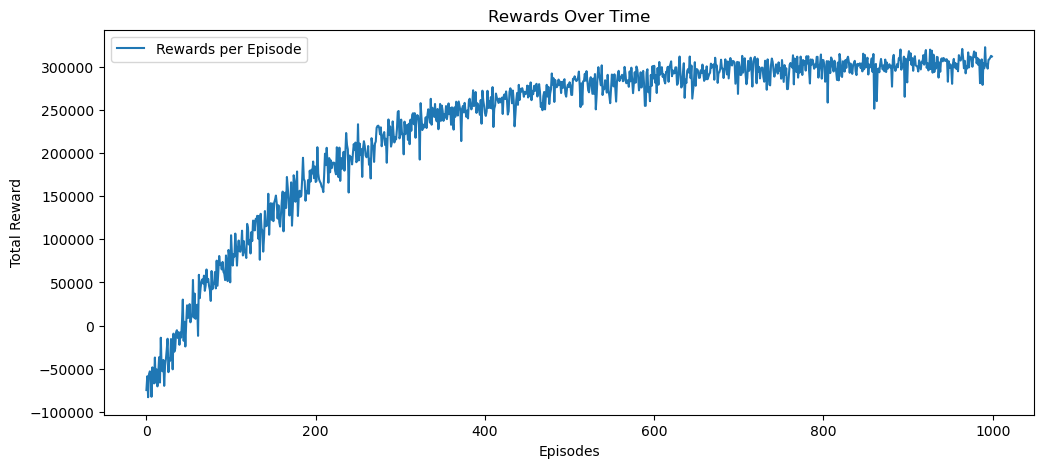

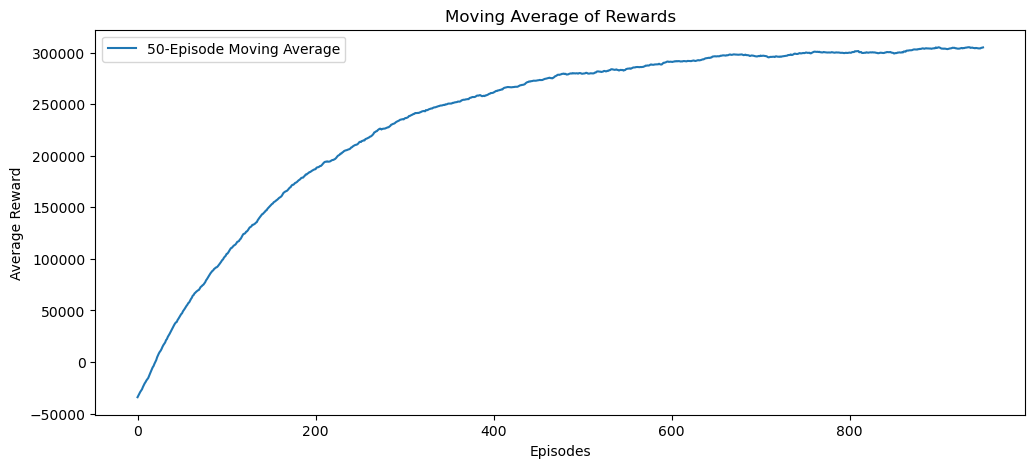

Optimal Action Sequence:
hour0: Draw from battery
hour1: Draw from battery
hour2: Draw from battery
hour3: Draw from battery
hour4: Draw from battery
hour5: Draw from battery
hour6: Draw from battery
hour7: Use solar energy
hour8: Store in battery
hour9: Store in battery
hour10: Use solar energy
hour11: Store in battery
hour12: Store in battery
hour13: Store in battery
hour14: Store in battery
hour15: Draw from battery
hour16: Draw from battery
hour17: Draw from battery
hour18: Draw from battery
hour19: Draw from battery
hour20: Draw from battery
hour21: Draw from battery
hour22: Draw from battery
hour23: Draw from battery
hour24: Draw from battery
hour25: Draw from battery
hour26: Draw from battery
hour27: Draw from battery
hour28: Draw from battery
hour29: Draw from battery
hour30: Draw from battery
hour31: Draw from battery
hour32: Store in battery
hour33: Store in battery
hour34: Draw from battery
hour35: Draw from battery
hour36: Store in battery
hour37: Draw from battery
hour38: 

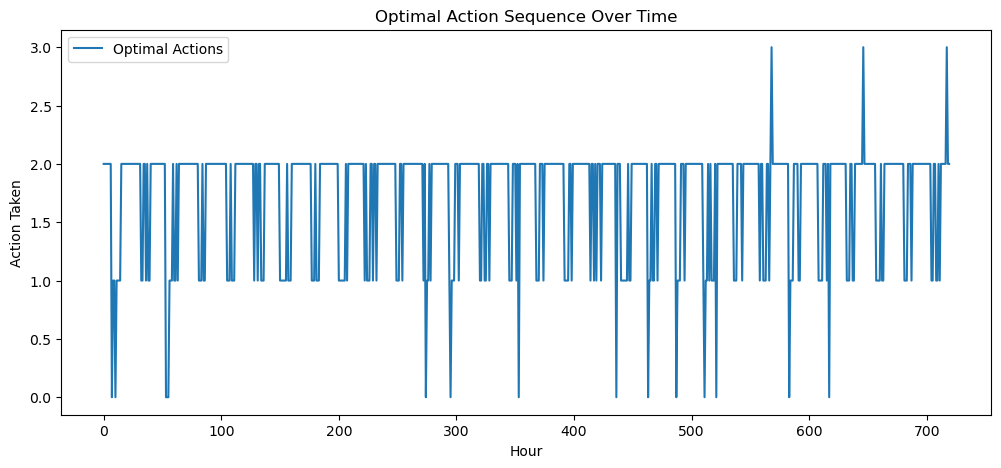

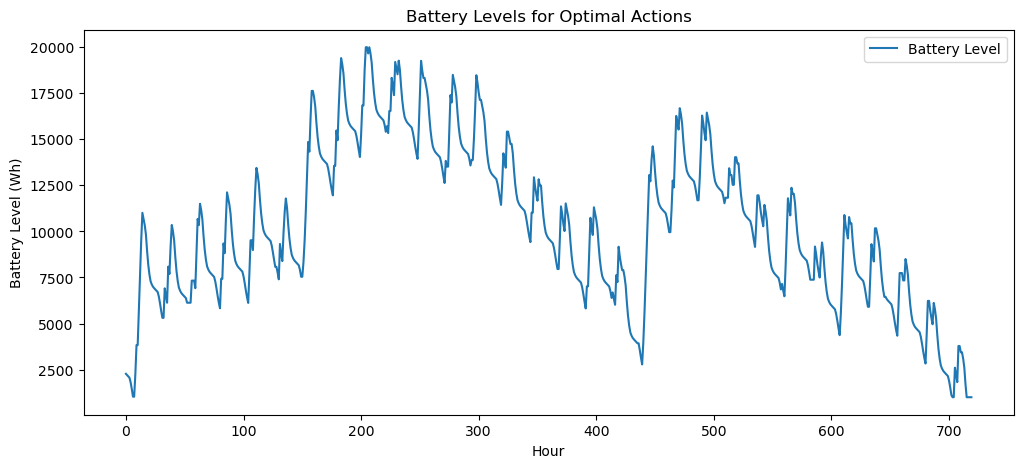

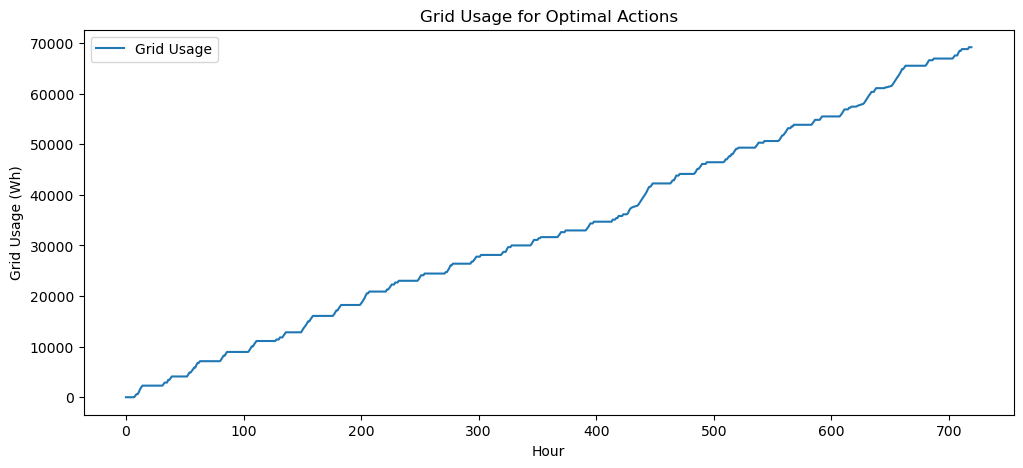

In [5]:
# Train the agent and display plots
rewards = q_learning_agent.train(episodes=1000, max_steps=720)


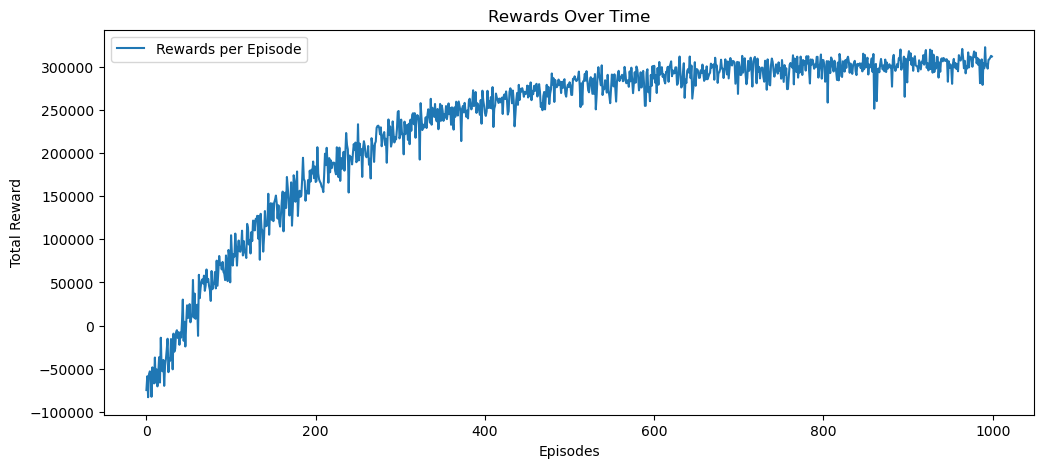

In [6]:
# Plot the rewards obtained in training
q_learning_agent.plot_rewards(rewards)




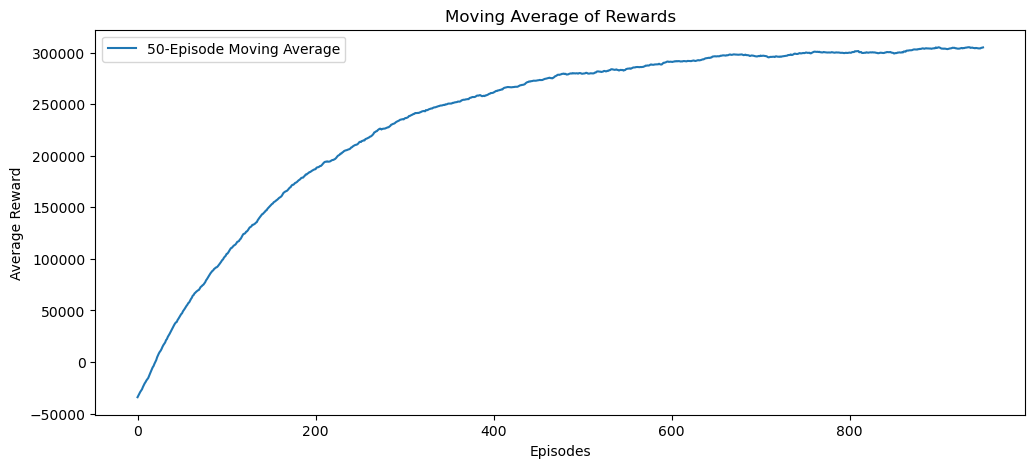

In [7]:
# Plot the moving average of rewards
q_learning_agent.plot_moving_average(rewards)



Optimal Action Sequence:
hour0: Draw from battery
hour1: Draw from battery
hour2: Draw from battery
hour3: Draw from battery
hour4: Draw from battery
hour5: Draw from battery
hour6: Draw from battery
hour7: Use solar energy
hour8: Store in battery
hour9: Store in battery
hour10: Use solar energy
hour11: Store in battery
hour12: Store in battery
hour13: Store in battery
hour14: Store in battery
hour15: Draw from battery
hour16: Draw from battery
hour17: Draw from battery
hour18: Draw from battery
hour19: Draw from battery
hour20: Draw from battery
hour21: Draw from battery
hour22: Draw from battery
hour23: Draw from battery
hour24: Draw from battery
hour25: Draw from battery
hour26: Draw from battery
hour27: Draw from battery
hour28: Draw from battery
hour29: Draw from battery
hour30: Draw from battery
hour31: Draw from battery
hour32: Store in battery
hour33: Store in battery
hour34: Draw from battery
hour35: Draw from battery
hour36: Store in battery
hour37: Draw from battery
hour38: 

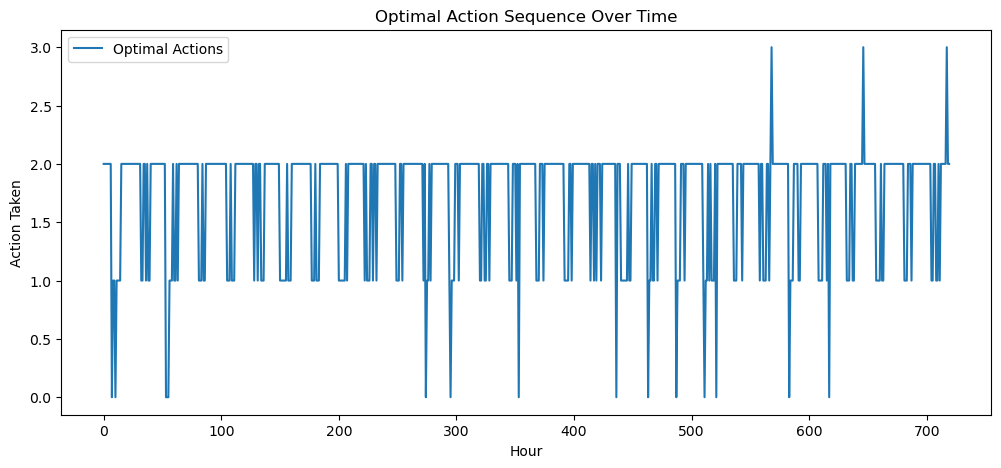

In [8]:
# Get the optimal action sequence and plot it
optimal_actions = q_learning_agent.extract_optimal_actions(rewards, q_learning_agent.actions_record)
q_learning_agent.plot_action_sequence(optimal_actions)



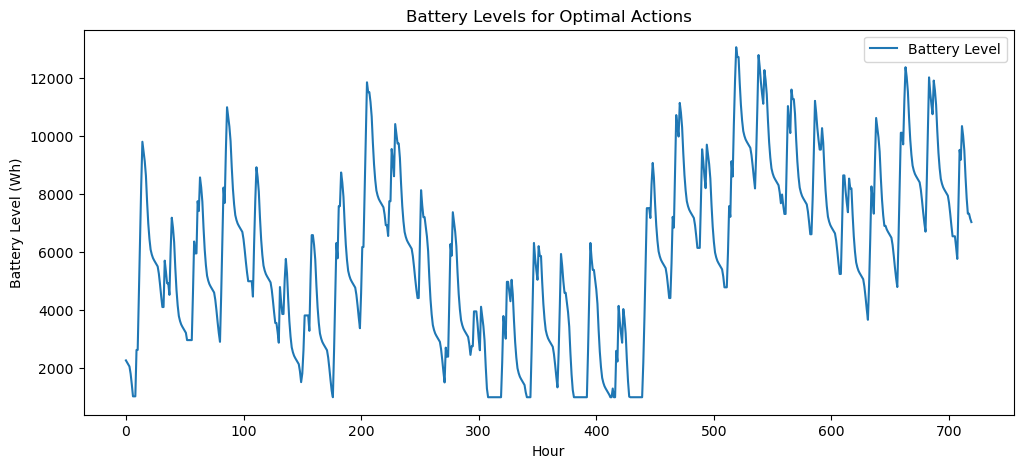

In [9]:
# Plot battery levels for the optimal action sequence
q_learning_agent.plot_battery_levels(optimal_actions)



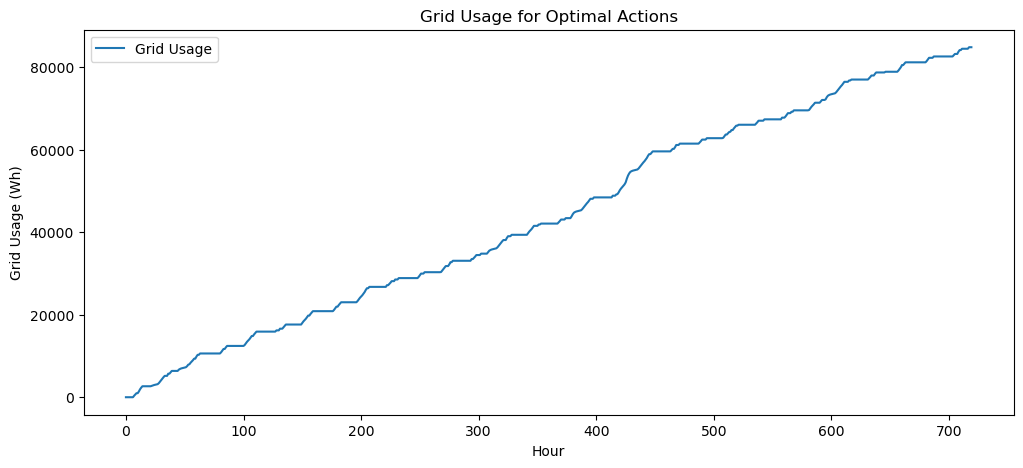

In [10]:
# Plot grid usage for the optimal action sequence
q_learning_agent.plot_grid_usage(optimal_actions)

In [11]:
# Calculate and display the total grid usage for the optimal actions
total_grid_usage = q_learning_agent.calculate_total_grid_usage(optimal_actions)
print("Total Grid Usage for Optimal Actions:", total_grid_usage/1000, "kWh")

Total Grid Usage for Optimal Actions: 61.46 kWh


In [12]:
brute_force_actions =[]
for i in range(720):
    hour = i % 24
    if hour < 6 or hour >= 18 :
        brute_force_actions.append(2)
    else:
        brute_force_actions.append(1)

In [13]:
total_grid_usage_actions =[]
for i in range(720):
    total_grid_usage_actions.append(2)

In [14]:
from scipy.optimize import minimize

# Define the environment's parameters
potential_number_of_days_without_solar = 2
battery_capacity = 10 * potential_number_of_days_without_solar*1000  # Battery capacity in Wh
min_battery = 1 * 1000  # Minimum charge level
max_battery = 10 * potential_number_of_days_without_solar* 1000  # Full battery charge
battery_charge_discharge_rate = 5 * 1000  # Battery charge/discharge rate in Wh
forecast_probability = 0.23  # Probability of overcast days

# 24-hour solar and load cycles
solar_cycle = np.array([0, 0, 0, 0, 0, 0, 0.15, 0.4, 0.6, 0.8, 0.9, 0.96, 0.98, 0.9, 0.75, 0.58, 0.37, 0.14, 0, 0, 0, 0, 0, 0]) * 1000* potential_number_of_days_without_solar
load_cycle = np.array([0.08, 0.07, 0.07, 0.07, 0.25, 0.37, 0.41, 0.37, 0.3, 0.31, 0.37, 0.41, 0.53, 0.4, 0.34, 0.33, 0.34, 0.5, 0.9, 0.75, 0.53, 0.37, 0.17, 0.12]) * 1000

# Define initial states
initial_battery_level = 2.35 * 1000
grid_usage = 0

def mpc_objective(actions, solar_forecast, load_forecast, battery_level):
    grid_usage = 0
    battery_level_temp = battery_level
    for i, action in enumerate(actions):
        if action == 0:  # Use solar energy to meet load
            if solar_forecast[i] >= load_forecast[i]:
                battery_level_temp += (solar_forecast[i] - load_forecast[i])  # Store excess solar in battery
            else:
                grid_usage += (load_forecast[i] - solar_forecast[i])  # Use grid if solar doesn't meet load

        elif action == 1:  # Store excess solar in battery
            if battery_level_temp + solar_forecast[i] <= max_battery:
                battery_level_temp += solar_forecast[i]
            else:
                grid_usage += load_forecast[i]  # Use grid if solar is unavailable

        elif action == 2:  # Draw from battery
            if battery_level_temp >= load_forecast[i]:
                battery_level_temp -= load_forecast[i]
            else:
                grid_usage += load_forecast[i] - battery_level_temp  # Use grid if battery can't meet load
                battery_level_temp = min_battery

        elif action == 3:  # Draw from grid
            grid_usage += load_forecast[i]

        battery_level_temp = max(min(battery_level_temp, max_battery), min_battery)
    
    return grid_usage

def optimize_actions(solar_forecast, load_forecast, battery_level):
    # Initial guess for actions over the horizon (random choices)
    initial_actions = np.random.choice([0, 1, 2, 3], size=len(solar_forecast))

    # Bounds and constraints are defined for each step
    bounds = [(0, 3) for _ in range(len(solar_forecast))]
    
    # Minimize grid usage by optimizing actions
    result = minimize(mpc_objective, initial_actions, args=(solar_forecast, load_forecast, battery_level),
                      bounds=bounds, method='SLSQP')

    # Ensure results are integers (since actions are discrete)
    optimal_actions = np.round(result.x).astype(int)
    return optimal_actions

# Simulate for a 30-day period (720 hours)
battery_level = initial_battery_level
grid_usage = 0
actions_taken = []

for day in range(30):
    is_overcast = np.random.rand() < forecast_probability
    solar_forecast = np.where(is_overcast, 0, solar_cycle)
    load_forecast = load_cycle

    # Optimize actions for the day (24-hour period)
    actions = optimize_actions(solar_forecast, load_forecast, battery_level)
    actions_taken.extend(actions)

    # Apply the actions and update battery and grid usage
    for hour, action in enumerate(actions):
        solar_energy = solar_forecast[hour]
        load = load_forecast[hour]
        
        if action == 0:  # Use solar to meet load
            if solar_energy >= load:
                battery_level += (solar_energy - load)  # Store excess in battery
            else:
                grid_usage += (load - solar_energy)  # Use grid

        elif action == 1:  # Store solar in battery
            if battery_level + solar_energy <= max_battery:
                battery_level += solar_energy
            else:
                grid_usage += load

        elif action == 2:  # Draw from battery
            if battery_level >= load:
                battery_level -= load
            else:
                grid_usage += (load - battery_level)
                battery_level = min_battery

        elif action == 3:  # Draw from grid
            grid_usage += load

        # Limit battery levels within bounds
        battery_level = max(min(battery_level, max_battery), min_battery)


MPC_actions = actions_taken.copy()


In [15]:

standard_usage_actions =[]
for i in range(720):
    hour = i % 24
    if hour < 6 or hour >= 18 :
        standard_usage_actions.append(2)
    else:
        standard_usage_actions.append(0)

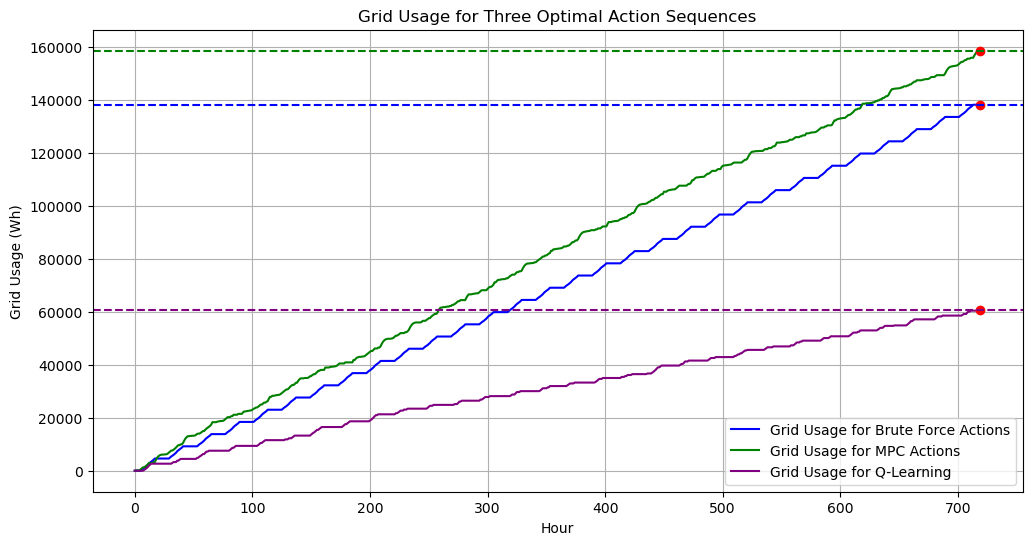

In [16]:
q_learning_agent.compare_grid_usage( brute_force_actions, MPC_actions, optimal_actions)

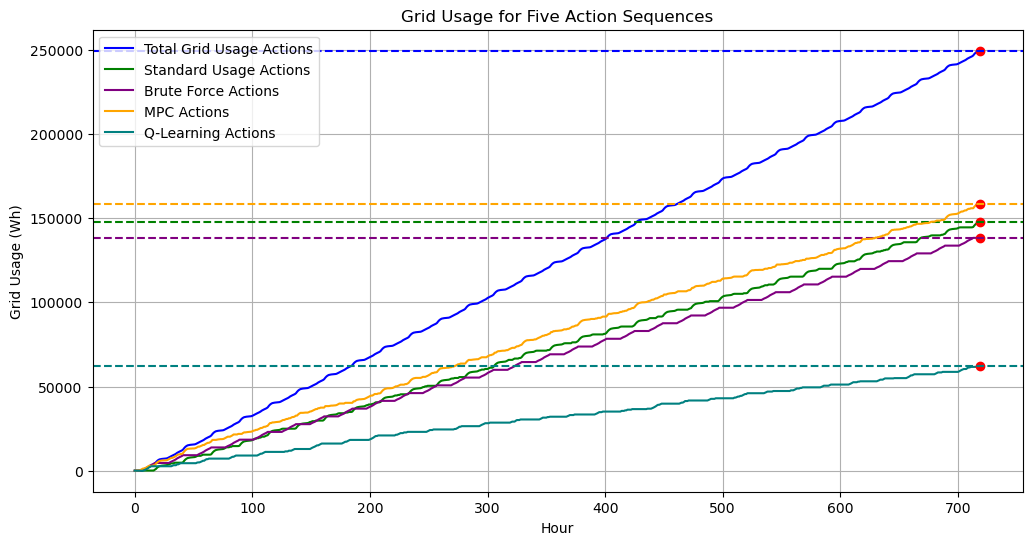

In [17]:
q_learning_agent.ultra_grid_usage(total_grid_usage_actions, standard_usage_actions, brute_force_actions, MPC_actions, optimal_actions)